_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Coding Lab 8



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style("whitegrid")
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-07-02 10:04:18CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

sklearn: 1.4.2

matplotlib: 3.8.4
seaborn   : 0.13.2
numpy     : 1.26.4

Watermark: 2.4.3



# Task 1: Implement entropy estimators


*Grading: 5 pts (basic) + 1 pts (advanced) + 3 pts (bonus)*

## General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


## Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## Basic
*Grading: 5 pts*

### MLE

*Grading: 1 pts*

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [ ]:
def entropy_mle(phat):
    """Maximum likelihood or plug-in estimator of discrete entropy

    Parameter
    ---------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    Return
    ------
    H: float
        Entropy estimate
    """
    # insert your code here (1 pt)
    phat = phat[phat > 0]  # avoid log(0)
    H = -np.sum(phat * np.log2(phat))

    return H

### Miller-Maddow corrected

*Grading: 1 pts*

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [ ]:
def entropy_mm(phat, n):
    """Miller-Maddow corrected estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n:  int
        Number of samples


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)
    dhat = np.sum(phat > 0)
    H = entropy_mle(phat) + (dhat - 1) / (2 * n)

    return H

### Jack-knife corrected

*Grading: 2 pts*

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [ ]:
def entropy_jk(x, edges):
    """Jack-knife corrected estimator of discrete entropy

    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples

    edges: np.array, shape=(n_bins, )
        Histogram bin edges


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (2 pt)
    n = x.size
    phat = np.histogram(x, bins=edges)[0] / n

    # calculate the maximum likelihood entropy
    H_ML = entropy_mle(phat)

    n_limit = min(
        n, 1000
    )  # limit the number of samples to 1000 for performance reasons
    H_JK = np.zeros(n_limit)
    for i in range(n_limit):
        # remove one sample
        phat_i = np.histogram(np.delete(x, i), bins=edges)[0] / (n - 1)
        # calculate entropy of the reduced sample
        H_JK[i] = entropy_mle(phat_i)

    # calculate the jack-knife corrected entropy
    H = n * H_ML - (n - 1) * np.mean(H_JK)

    return H

### Coverage-adjusted

*Grading: 1 pts*

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [ ]:
def entropy_cae(phat, n):
    """coverage-adjusted estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n: int
        Number of samples.


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    #  estimate the coverage probability C
    f1 = np.sum(phat == 1 / n)  # Number of singletons (frequency of 1)
    C = 1 - f1 / n

    phat_C = phat * C
    phat_C = phat_C[phat_C > 0]  # avoid log(0)

    H = -np.sum((phat_C * np.log2(phat_C)) / (1 - (1 - phat_C) ** n))

    return H

## Advanced
*Grading: 1 + 3 pts*

### JVHW
*Grading: 1 pts*

In [ ]:
# we use the implementation of the JVHW estimator from https://github.com/EEthinker/JVHW_Entropy_Estimators/blob/master/Python/est_entro.py
# to load the poly_entro coefficients the file poly_coeff_entro.mat has to be in the same directory as this notebook
import scipy.io as sio

poly_entro = None


def entro_mat(x, n, g_coeff, c_1):
    # g_coeff = {g0, g1, g2, ..., g_K}, K: the order of best polynomial approximation,
    K = len(g_coeff) - 1
    thres = 4 * c_1 * np.log(n) / n
    T, X = np.meshgrid(thres, x)
    ratio = np.minimum(np.maximum(2 * X / T - 1, 0), 1)
    q = np.arange(K).reshape((1, 1, K))
    g = g_coeff.reshape((1, 1, K + 1))
    MLE = -X * np.log(X) + 1 / (2 * n)
    polyApp = np.sum(
        np.concatenate(
            (T[..., None], ((n * X)[..., None] - q) / (T[..., None] * (n - q))), axis=2
        ).cumprod(axis=2)
        * g,
        axis=2,
    ) - X * np.log(T)
    polyfail = np.isnan(polyApp) | np.isinf(polyApp)
    polyApp[polyfail] = MLE[polyfail]
    output = ratio * MLE + (1 - ratio) * polyApp
    return np.maximum(output, 0)


def est_entro_MLE(samp):
    """Maximum likelihood estimate of Shannon entropy (in bits) of the input
    sample

    This function returns a scalar MLE of the entropy of samp when samp is a
    vector, or returns a (row-) vector consisting of the MLE of the entropy
    of each column of samp when samp is a matrix.

    Input:
    ----- samp: a vector or matrix which can only contain integers. The input
                data type can be any interger classes such as uint8/int8/
                uint16/int16/uint32/int32/uint64/int64, or floating-point
                such as single/double.
    Output:
    ----- est: the entropy (in bits) of the input vector or that of each
               column of the input matrix. The output data type is double.
    """
    samp = formalize_sample(samp)
    [n, wid] = samp.shape
    n = float(n)

    f = fingerprint(samp)
    prob = np.arange(1, f.shape[0] + 1) / n
    prob_mat = -prob * np.log2(prob)
    return prob_mat.dot(f)


def formalize_sample(samp):
    samp = np.array(samp)
    if np.any(samp != np.fix(samp)):
        raise ValueError("Input sample must only contain integers.")
    if samp.ndim == 1 or samp.ndim == 2 and samp.shape[0] == 1:
        samp = samp.reshape((samp.size, 1))
    return samp


def fingerprint(samp):
    """A memory-efficient algorithm for computing fingerprint when wid is
    large, e.g., wid = 100
    """
    wid = samp.shape[1]

    d = np.r_[
        np.full((1, wid), True, dtype=bool),
        np.diff(np.sort(samp, axis=0), 1, 0) != 0,
        np.full((1, wid), True, dtype=bool),
    ]

    f_col = []
    f_max = 0

    for k in range(wid):
        a = np.diff(np.flatnonzero(d[:, k]))
        a_max = a.max()
        hist, _ = np.histogram(a, bins=a_max, range=(1, a_max + 1))
        f_col.append(hist)
        if a_max > f_max:
            f_max = a_max

    return np.array([np.r_[col, [0] * (f_max - len(col))] for col in f_col]).T


def entropy_jvhw(x):
    """JVHW estimator of discrete entropy.

    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples

    Return
    ------
    H: float
        Entropy estimate
    """

    samp = formalize_sample(x)
    [n, wid] = samp.shape
    n = float(n)

    # The order of polynomial is no more than 22 because otherwise floating-point error occurs
    order = min(4 + int(np.ceil(1.2 * np.log(n))), 22)
    global poly_entro
    if poly_entro is None:
        poly_entro = sio.loadmat("poly_coeff_entro.mat")["poly_entro"]
    coeff = poly_entro[order - 1, 0][0]

    f = fingerprint(samp)

    prob = np.arange(1, f.shape[0] + 1) / n

    # Piecewise linear/quadratic fit of c_1
    V1 = np.array([0.3303, 0.4679])
    V2 = np.array([-0.530556484842359, 1.09787328176926, 0.184831781602259])
    f1nonzero = f[0] > 0
    c_1 = np.zeros(wid)

    with np.errstate(divide="ignore", invalid="ignore"):
        if n >= order and f1nonzero.any():
            if n < 200:
                c_1[f1nonzero] = np.polyval(V1, np.log(n / f[0, f1nonzero]))
            else:
                n2f1_small = f1nonzero & (np.log(n / f[0]) <= 1.5)
                n2f1_large = f1nonzero & (np.log(n / f[0]) > 1.5)
                c_1[n2f1_small] = np.polyval(V2, np.log(n / f[0, n2f1_small]))
                c_1[n2f1_large] = np.polyval(V1, np.log(n / f[0, n2f1_large]))

            # make sure nonzero threshold is higher than 1/n
            c_1[f1nonzero] = np.maximum(c_1[f1nonzero], 1 / (1.9 * np.log(n)))

        prob_mat = entro_mat(prob, n, coeff, c_1)

    H = np.sum(f * prob_mat, axis=0) / np.log(2)

    return H[0]

### Bonus points: Unseen or Best Upper Bounds estimator
*Grading: 3 bonus pts*

In [ ]:
# insert your code here

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)
# ------------------------------------------

# we implement the Unseen estimator in Python according to the paper
# as the code wasn't provided at the time we worked on this notebook, we used the code from the papers supplemental material:
# https://proceedings.neurips.cc/paper_files/paper/2013/file/53c04118df112c13a8c34b38343b9c10-Supplemental.zip

from collections import Counter
from scipy.optimize import linprog
from scipy.stats import poisson


def make_finger(v):
    """
    Computes the number of elements that occur exactly i times.
    f(i) = |{x in v: x occurs i times}|
    Input:
    v: np.array, shape=(n_samples, )
        Samples
    Output:
    f: np.array, shape=(I, )
        Histogram of occurrences, length depends on the data
    """

    # Compute the histogram of occurrences of each element in v
    element_counts = Counter(v)

    # Compute the histogram of these counts
    count_values = list(element_counts.values())
    max_count = max(count_values)
    count_hist = np.histogram(count_values, bins=np.arange(max_count + 2))[0]

    # Remove the first element which corresponds to zero count
    f = count_hist[1:]

    return f


def entropy_unseen(samples):
    """
    Unseen estimator of discrete entropy.
    Input:
    samples: np.array, shape=(n_samples, )
        Samples
    Output:
    H: float
        Entropy estimate
    """

    # Compute the fingerprint of the data
    f = np.array(make_finger(samples)).flatten()
    k = samples.shape[0]  # np.dot(f, np.arange(1, len(f) + 1)) # number of samples

    # Algorithm parameters
    gridFactor = 1.1  # the grid of probabilities will be geometric, with this ratio.
    alpha = 0.5  # the allowable discrepancy between the returned solution and the "best" (overfit)
    xLPmin = 1 / (k * max(10, k))  # minimum allowable probability
    maxLPIters = 1000  # the 'MaxIter' parameter for 'linprog' LP solver.

    # Split the fingerprint into the 'dense' portion for which we
    # solve an LP to yield the corresponding histogram, and 'sparse'
    # portion for which we simply use the empirical histogram
    probx = [0]
    histx = [0]
    fLP = np.zeros(f.size)  # stores the dense portion to be used in LP

    for i in range(1, f.size + 1):  # as first i is 1
        if f[i - 1] > 0:
            wind = [
                max(1, i - int(np.ceil(np.sqrt(i)))),
                min(i + int(np.ceil(np.sqrt(i))), f.size),
            ]
            if np.sum(f[wind[0] - 1 : wind[1]]) < 2 * np.sqrt(i):
                probx.append(i / k)
                histx.append(f[i - 1])
                fLP[i - 1] = 0
            else:
                fLP[i - 1] = f[i - 1]

    # If no LP portion, return the empirical entropy
    positive_indices = np.where(fLP > 0)[0]
    if positive_indices.size == 0:
        probx = probx[1:]
        histx = histx[1:]
        return -np.dot(histx, (probx * np.log2(probx)))

    fmax = np.max(positive_indices) + 1

    # Set up the first LP
    LPmass = 1 - np.dot(probx, histx)  # amount of probability mass in the LP region

    fLP = np.append(fLP[:fmax], np.zeros(int(np.ceil(np.sqrt(fmax)))))
    szLPf = fLP.size

    xLPmax = fmax / k
    xLP = xLPmin * gridFactor ** np.arange(
        0, int(np.ceil(np.log(xLPmax / xLPmin) / np.log(gridFactor))) + 1
    )
    szLPx = xLP.size

    objf = np.zeros(szLPx + 2 * szLPf)
    objf[szLPx::2] = 1 / np.sqrt(fLP + 1)  # discrepancy in ith fingerprint expectation
    objf[szLPx + 1 :: 2] = 1 / np.sqrt(fLP + 1)  # weighted by 1/sqrt(f(i) + 1)

    A = np.zeros((2 * szLPf, szLPx + 2 * szLPf))
    b = np.zeros(2 * szLPf)
    # Fill the matrix A and vector b
    for i in range(1, szLPf + 1):
        poisson_pmf = poisson.pmf(i, k * xLP)

        # Python uses zero-based indexing, so adjustments are made
        A[2 * i - 2, :szLPx] = poisson_pmf
        A[2 * i - 1, :szLPx] = -poisson_pmf
        A[2 * i - 2, szLPx + 2 * i - 2] = -1
        A[2 * i - 1, szLPx + 2 * i - 1] = -1
        b[2 * i - 2] = fLP[i - 1]  # Adjust index for zero-based indexing
        b[2 * i - 1] = -fLP[i - 1]  # Adjust index for zero-based indexing

    Aeq = np.zeros(szLPx + 2 * szLPf)
    Aeq[:szLPx] = xLP
    beq = LPmass

    options = {"maxiter": maxLPIters, "disp": False}
    for i in range(szLPx):
        A[:, i] /= xLP[i]  # rescaling for better conditioning
        Aeq[i] /= xLP[i]

    bounds = [(0, None)] * (
        szLPx + 2 * szLPf
    )  # list of tuples with (lower_bound=0, upper_bound=Inf)
    res = linprog(
        objf,
        A_ub=A,
        b_ub=b,
        A_eq=Aeq.reshape(1, -1),
        b_eq=[beq],
        bounds=bounds,
        options={"maxiter": maxLPIters, "disp": False},
    )
    # if res.status == 0:
    #     print("maximum number of iterations reached--try increasing maxLPIters")

    # if res.status < 0:
    #     print("LP1 solution was not found, still solving LP2 anyway...")

    # Solve the 2nd LP, which minimizes support size subject to incurring at most
    # alpha worse objective function value (of the objective function in the previous LP).
    objf2 = np.zeros_like(objf)
    objf2[:szLPx] = 1

    A2 = np.vstack([A, objf])  # ensure at most alpha worse obj value
    b2 = np.hstack([b, res.fun + alpha])  # than solution of previous LP

    for i in range(szLPx):
        objf2[i] /= xLP[i]  # rescaling for better conditioning

    res2 = linprog(
        objf2,
        A_ub=A2,
        b_ub=b2,
        A_eq=Aeq.reshape(1, -1),
        b_eq=[beq],
        bounds=bounds,
        options={"maxiter": maxLPIters, "disp": False},
    )
    # if res2.status != 1:
    #     print("LP2 solution was not found")

    # append LP solution to empirical portion of histogram
    res2.x[:szLPx] /= xLP  # removing the scaling
    probx = np.concatenate((probx, xLP))
    histx = np.concatenate((histx, res2.x))

    # Sort x and get the sorted indices
    sorted_indices = np.argsort(probx)
    probx = probx[sorted_indices]
    histx = histx[sorted_indices]

    # Find indices where histx is greater than 0
    positive_indices = np.where(histx > 0)[0]

    # Filter x and histx with positive indices
    probx = probx[positive_indices]
    histx = histx[positive_indices]

    # Output entropy of the recovered histogram
    estimatedEntropy = -np.dot(histx, probx * np.log2(probx))
    return estimatedEntropy

# Task 2: Distributions
*Grading: 4 pts*

## Uniform distribution
*Grading: 2 pts*

In [ ]:
D = 10
N = 2**D

p = 1 / N * np.ones(N)  # true distribution

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

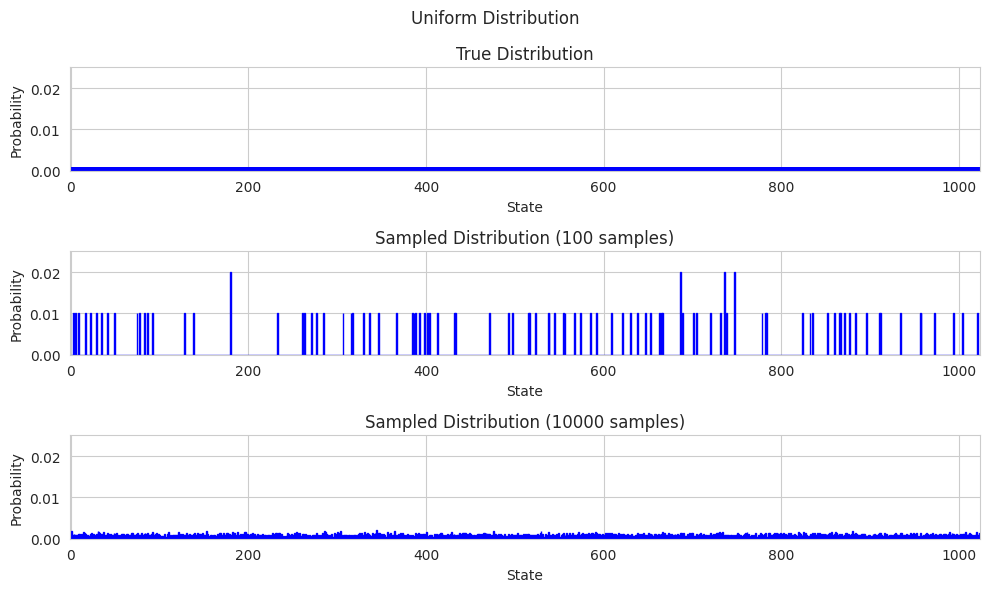

In [ ]:
# insert your code here
rng = np.random.default_rng(0)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
# draw 100 samples from discrete uniform distribution with N states
samples_100 = rng.integers(0, N, 100)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------
samples_10000 = rng.integers(0, N, 10000)

# ------------------------------------
# Plot the true distribution and
# the sampled distributions. (0.5 pts)
# ------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

axs[0].bar(np.arange(N), p, linewidth=0, width=1.0, color="b")
axs[0].set_title("True Distribution")

axs[1].hist(samples_100, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[1].set_title("Sampled Distribution (100 samples)")

axs[2].hist(samples_10000, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[2].set_title("Sampled Distribution (10000 samples)")

for ax in axs:
    ax.set_xlim(-1, N)
    ax.set_ylim(0, 0.025)
    ax.set_xlabel("State")
    ax.set_ylabel("Probability")

plt.suptitle("Uniform Distribution")
plt.tight_layout()
plt.show()

##### Observation

For a sample size of 100 the variation and deviation from the true distribution is clearly noticeable. For 10000 samples the distribution approximates the true distribution much better, as it shows less variation.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [ ]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(1)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))
h_unseen = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------

        # draw S samples from uniform distribution
        x = rng.integers(0, N, size=int(S))

        # create a histogram using the predefined edges
        counts, _ = np.histogram(x, bins=edges)

        # calculate phat
        phat = counts / np.sum(counts)

        # normalize counts to get phat
        phat = counts / np.sum(counts)

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_jk[i, j] = entropy_jk(
            x, edges
        )  # resampled to min 1000 samples for the jackknife part (see function implementation)
        h_jvhw[i, j] = entropy_jvhw(x)
        h_unseen[i, j] = entropy_unseen(x)

Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

<matplotlib.legend.Legend>

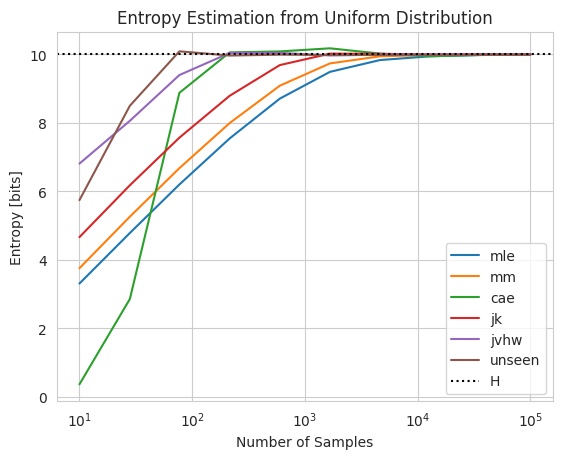

In [ ]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")
plt.semilogx(sample_sizes, np.mean(h_unseen, axis=1), label="unseen")


plt.axhline(H, color="black", linestyle=":", label="H")
plt.xlabel("Number of Samples")
plt.ylabel("Entropy [bits]")
plt.title("Entropy Estimation from Uniform Distribution")
plt.legend()

#### Observation

The Unseen estimator provides a very close estimate first with about 10² samples and seems to perform best. The JVHK estimator also shows good results. From the primitive estimator each performs bad with sparse sampling, especially CAE. Starting at about 10² samples however the CAE performs better than the other primitive estimators.

## Zipf distribution
*Grading: 2 pts*

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [ ]:
D = 10
N = 2**D

p = 1 / (np.arange(0, N) + 1)  # true distribution
p = p / np.sum(p)

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `choice` of numpys random number generator is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

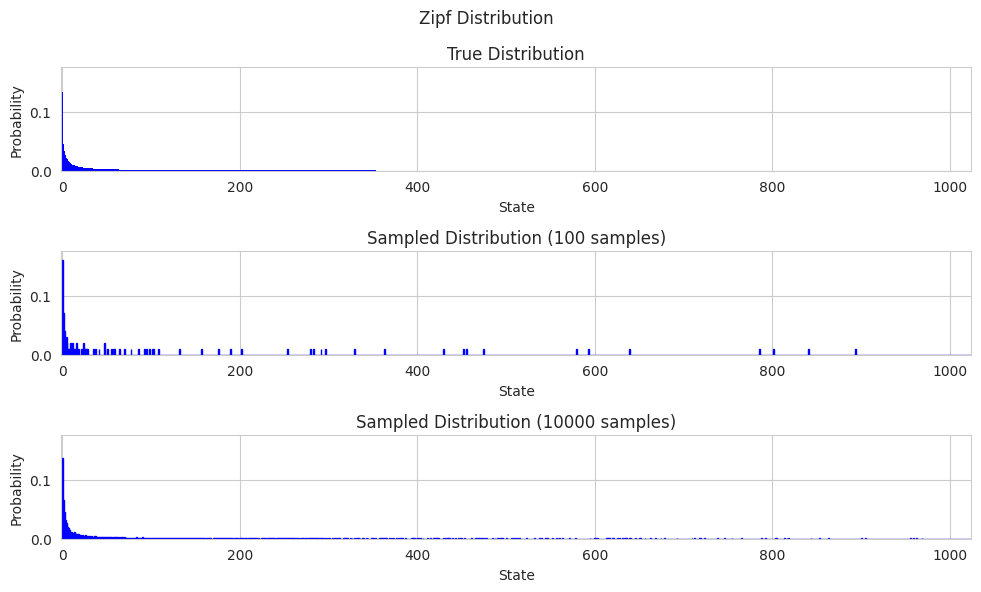

In [ ]:
# insert your code here
rng = np.random.default_rng(2)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------
samples_100 = rng.choice(np.arange(N), size=100, p=p)


# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------
samples_10000 = rng.choice(np.arange(N), size=10000, p=p)


# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

axs[0].bar(np.arange(N), p, linewidth=0, width=1.0, color="b")
axs[0].set_title("True Distribution")

axs[1].hist(samples_100, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[1].set_title("Sampled Distribution (100 samples)")

axs[2].hist(samples_10000, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[2].set_title("Sampled Distribution (10000 samples)")

for ax in axs:
    ax.set_xlim(-1, N)
    ax.set_ylim(0, 0.175)
    ax.set_xlabel("State")
    ax.set_ylabel("Probability")

plt.suptitle("Zipf Distribution")
plt.tight_layout()
plt.show()

#### Observation

Sampling from a Zipf distribution yields good results even for a low number of samples (i.e. 100), as the most drawn samples are approximately in states 0 to 100. But of course the probability for states in higher regions with just 100 samples is still too high.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [ ]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(3)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))
h_unseen = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):
        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------

        # draw S samples from Zipf distribution
        x = rng.choice(np.arange(N), size=int(S), p=p)

        # create a histogram using the predefined edges
        counts, _ = np.histogram(x, bins=edges)

        # calculate phat
        phat = counts / np.sum(counts)

        # normalize counts to get phat
        phat = counts / np.sum(counts)

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_jk[i, j] = entropy_jk(
            x, edges
        )  # resampled to min 1000 samples for the jackknife part (see function implementation)
        h_jvhw[i, j] = entropy_jvhw(x)
        h_unseen[i, j] = entropy_unseen(x)

Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

<matplotlib.legend.Legend>

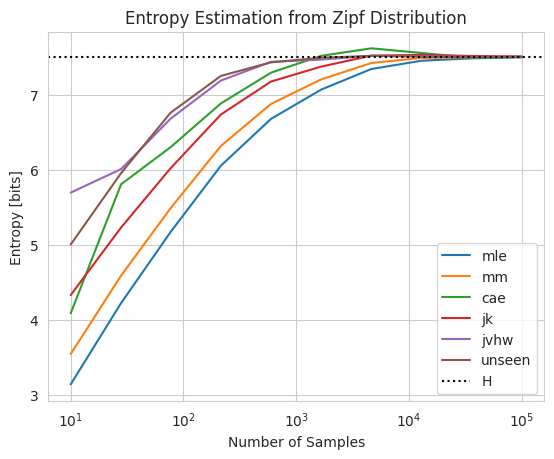

In [ ]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")
plt.semilogx(sample_sizes, np.mean(h_unseen, axis=1), label="unseen")

plt.axhline(H, color="black", linestyle=":", label="H")
plt.xlabel("Number of Samples")
plt.ylabel("Entropy [bits]")
plt.title("Entropy Estimation from Zipf Distribution")
plt.legend()

#### Observation

With the Zipf distribution the primitive estimators need much more samples to provide a good entropy estimate than in the uniform distribution case. But the two advanced approaches need more samples as well. In this run the JVHW appears to be slightly better (both are really close, JVHW just has a better start) than the Unseen estimator, but this might change adjusting the parameters of the Unseen algorithm.